# Clothes Classification

## Import packages

In [58]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from random import randint
from tqdm import tqdm

In [70]:
tqdm.pandas()

## Explore data
The following dataset was made by Zalando Data Science team, and it is fully described [here](https://arxiv.org/pdf/1708.07747.pdf).

It contains preprocessed clothes photos, in format of 28 x 28 matrices in grayscale (0 to 255).

There are 10 labels in dataset:

0. T-shirt/top
1. Trouser
2. Pullover
3. Dress
4. Coat
5. Sandal
6. Shirt
7. Sneaker
8. Bag
9. Ankle boot

In [2]:
label_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

### Training set checkout

In [3]:
tr_set = pd.read_csv("data/fashion-mnist_train.csv")

In [4]:
tr_set.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(array([6000., 6000., 6000., 6000., 6000., 6000., 6000., 6000., 6000.,
        6000.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

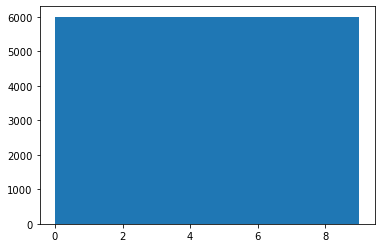

In [5]:
plt.hist(tr_set['label'])

So we can see that the training data is equally composed.

Let's try to look at random sample:

In [15]:
def show_sample(sample_id, dataset):
    sample = dataset.iloc[[sample_id]]
    label = int(sample['label'])
    img = np.array(sample, dtype='float')
    img = img[:, 1:]
    img = img.reshape((28,28))

    plt.imshow(img, cmap='gray')
    plt.title("Label {0}: {1} - sample {2}".format(label, label_names[label], sample_id))
    plt.show()

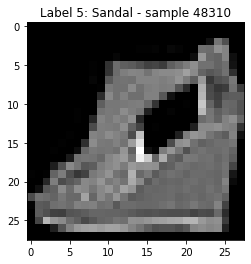

In [30]:
show_sample(randint(0,60000), tr_set)

### Test set checkout
We can also check composition of test set:

(array([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

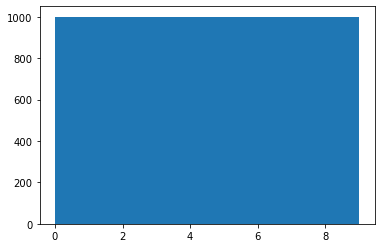

In [8]:
tst_set = pd.read_csv('data/fashion-mnist_test.csv')
plt.hist(tst_set['label'])

And it is also well composed like training set - each label has 1000 samples.

### Labels differences
We will check full dataset - both train and test data. Also, I will add `label_name` column to make comparision more clearly

In [9]:
full_set = pd.concat([tr_set, tst_set])
full_set['label_name'] = pd.DataFrame([label_names[el] for el in list(full_set.iloc[:, 0].astype(int))])

#### Composition of white pixels
Now we can try to spot differences between each clothes types. For example, sandals have much less white pixels than ankle boots. Let's see comparision of classes.

In [10]:
full_set['pixels_sum'] = full_set.iloc[:, 1:-1].sum(axis=1)
labels_pixels_sum = full_set.groupby(by=['label_name'])['pixels_sum'].mean()

In [11]:
labels_pixels_sum

label_name
Ankle boot     59999.078596
Bag            68809.013192
Coat           74199.152601
Dress          52686.620793
Pullover       72672.227881
Sandal         31586.809789
Shirt          65265.959271
Sneaker        37018.868552
T-shirt/top    63927.906977
Trouser        46298.467298
Name: pixels_sum, dtype: float64

<AxesSubplot:xlabel='label_name'>

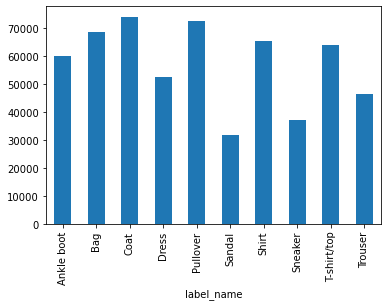

In [12]:
labels_pixels_sum.plot.bar()

As we can see above, the labels have different mean of `pixels_sum`. *Coat* by average has the most white pixels, whereas *sandal* has the least.

#### White pixels symetry
Another difference between clothes, may be their symetry. *Trouser* are definitely symmetrical, while *boot* is not. Let's create `symmetrical` parameter and calculate it for each sample.

In [83]:
def calc_symmetry(pixels, tolerance):
    '''
    @param: pixels - one dim list of pixels, from 0 to 784
    @param: tolerance - how big the difference between mirror pixels can be
    
    @return: symmetry coefficient - amount of symmetrical pairs by total amount of pairs (392)
    '''
    
    sym_pairs = 0
    
    for i in range(0, 784, 28):
        for j in range(0, 14):
            if abs(pixels[i+j] - pixels[i+27-j]) < tolerance:
                sym_pairs += 1
                
    return sym_pairs/392
        

In [84]:
full_set['symmetrical'] = full_set.progress_apply(lambda row: calc_symmetry(list(row.iloc[1:785]), tolerance=5), axis=1)

100%|██████████████████████████████████████████████████████████████████████████| 70000/70000 [00:32<00:00, 2169.28it/s]


In [85]:
labels_avg_symmetry = full_set.groupby(by=['label_name'])['symmetrical'].mean()
labels_avg_symmetry

label_name
Ankle boot     0.393831
Bag            0.519711
Coat           0.523213
Dress          0.638159
Pullover       0.533227
Sandal         0.598874
Shirt          0.507692
Sneaker        0.618731
T-shirt/top    0.573640
Trouser        0.647046
Name: symmetrical, dtype: float64

<AxesSubplot:xlabel='label_name'>

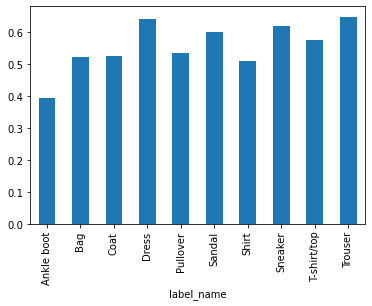

In [86]:
labels_avg_symmetry.plot.bar()

For `tolerance` equals 5 points of grayscale, it can be observed that *Ankle boot* is less symmetrical than other clothes. There is group of clothes with symmetry about 50% - *bag, coat, pullover* and *shirt*. The most symmetrical are *dress* and *trouser*.